<a href="https://colab.research.google.com/github/kimtiraj/deep-learning-pytorch/blob/main/cnn/Handwritten_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 5.4MB/s 


In [ ]:
project_name="CNN-using-PyTorch-project"

In [ ]:
# Save project
!pip install jovian --upgrade -q
import jovian
jovian.commit(project=project_name)

In [ ]:
# Import needed libraries for dataset creation
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import tarfile

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
#Dataset downloading
# Definition of train and test transformations
train_tfms = tt.Compose(
        [tt.Grayscale(num_output_channels=1),
         tt.RandomCrop(32, padding=4, padding_mode='reflect'),
         #tt.RandomHorizontalFlip(), # contra prductive for letter classification
         tt.ToTensor()])
test_tfms = tt.Compose(
        [tt.Grayscale(num_output_channels=1),
         tt.ToTensor()])

In [ ]:
# defining the training and testing set
train_dataset = datasets.MNIST('./data', download=True, train=True, transform=train_tfms)
test_dataset = datasets.MNIST('./', download=True, train=False, transform=train_tfms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


In [ ]:
dataset_size = len(train_dataset)
dataset_size

60000

In [ ]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [ ]:
classes = train_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# Check first dataset element
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([1, 32, 32]) 5


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
img, label = train_dataset[0]
img_shape = img.shape
img_shape

torch.Size([1, 32, 32])

In [ ]:
# Create show function to view sample images
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img[0])

Label:  4 - four (4)


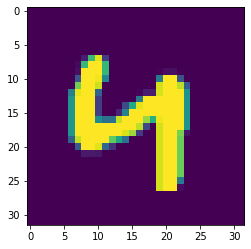

In [ ]:
# Show sample image, first image of the dataset
show_example(*train_dataset[222])

Label:  8 - eight (8)


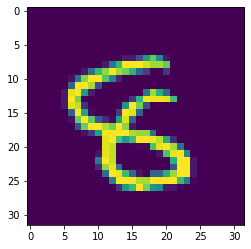

In [ ]:
# Show sample image, first image of the dataset
show_example(*train_dataset[792])

In [ ]:
# Set seed for rundom number generation
random_seed = 123
torch.manual_seed(random_seed);

In [ ]:
# Set validation dataset size and create the train and validation dataset
val_size = 95
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(59905, 95)

In [ ]:
# Import needed libraries for dataloaders and set batch size
from torch.utils.data.dataloader import DataLoader
batch_size=120

In [ ]:
# Create train and validation dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Import needed libraries to create an image example grid
from torchvision.utils import make_grid
# Define function to create an image grid which shows sample images, based on the dataset
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


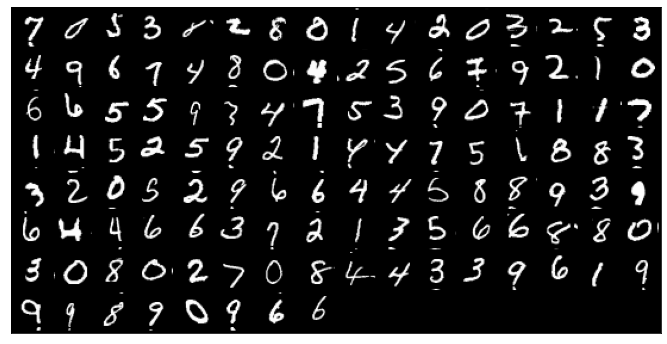

In [ ]:
# Show image grid (takes a bit to generate...)
show_batch(train_dl)

In [ ]:
# Import needed libraries for ml
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Modelling and Training
# Model definition, class ImageClassificationBase contains helper methods for training and validation. That class extends the nn.Module class.
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Model definition, class CyrilliclettersModel contains layer chaining and activations functions, nn.Sequential is used. That class extends our ImageClassificationBase class.
class CNN_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 34))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Initiate the model
model = CNN_Model()
#model

In [ ]:
# Model verification, a batch of training data is given to see if it generates the output as expected. It gives an output of 34 probabilities, each output
# stands for a letter, the highest output stands for the predicted label.
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([120, 1, 32, 32])
out.shape: torch.Size([120, 34])
out[0]: tensor([ 0.0120, -0.0233,  0.0332,  0.0110,  0.0377, -0.0413, -0.0137, -0.0209,
         0.0338, -0.0057, -0.0299, -0.0292,  0.0068, -0.0123, -0.0314, -0.0254,
        -0.0148,  0.0032, -0.0175, -0.0296,  0.0037,  0.0056,  0.0442, -0.0165,
        -0.0012,  0.0105, -0.0354, -0.0149,  0.0355,  0.0257,  0.0031, -0.0141,
         0.0023,  0.0007], grad_fn=<SelectBackward>)


In [ ]:
# Define helper functions for GPU use
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Check which device is available, cuda stands for Nvidia graphic card existence
device = get_default_device()
device# Check which device is available, cuda stands for Nvidia graphic card existence
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Wrap train and validation dataloader to use DeviceDataLoader if GPU is available, then use to_device to move the model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
# Define evaluate function to mesure the validation set performance
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Define fit function to train the model using gradiant descent
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Initiate model again to see the performance, using the initial set of parameters
model = to_device(CNN_Model(), device)

In [ ]:
# Show performance, using the initial set of parameters
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.0, 'val_loss': 3.5230517387390137}

In [ ]:
# Save project

import jovian
jovian.commit(project=project_name)

In [ ]:
# Set hyperparameters for training
num_epochs = 10
opt_func = torch.optim.SGD
lr = 0.00001

In [ ]:
# Record hyperparameters
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
# Train the model
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 3.5253, val_loss: 3.5226, val_acc: 0.0000
Epoch [1], train_loss: 3.5248, val_loss: 3.5221, val_acc: 0.0000
Epoch [2], train_loss: 3.5243, val_loss: 3.5216, val_acc: 0.0000
Epoch [3], train_loss: 3.5238, val_loss: 3.5211, val_acc: 0.0000
Epoch [4], train_loss: 3.5233, val_loss: 3.5207, val_acc: 0.0000
Epoch [5], train_loss: 3.5229, val_loss: 3.5202, val_acc: 0.0000
Epoch [6], train_loss: 3.5224, val_loss: 3.5197, val_acc: 0.0105
Epoch [7], train_loss: 3.5219, val_loss: 3.5192, val_acc: 0.1053
Epoch [8], train_loss: 3.5214, val_loss: 3.5188, val_acc: 0.1053
Epoch [9], train_loss: 3.5209, val_loss: 3.5183, val_acc: 0.1053


In [ ]:
  # Record the achieved metrics
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [ ]:
#Plotting
# Define function to visualize the model accuracy
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

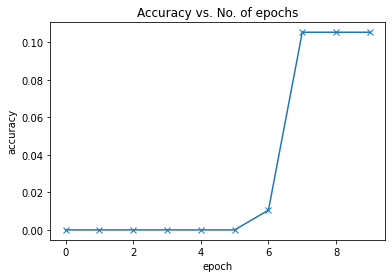

In [ ]:
# Show model accuracy
plot_accuracies(history)

In [ ]:
# Define function to visualize training and validation losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

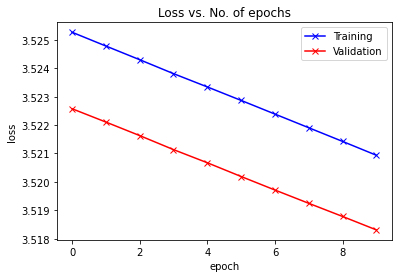

In [ ]:
# Show losses
plot_losses(history)

In [ ]:
#Prediction
# Define prediction function which reads test images and predicts the lables
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: 5 - five , Predicted: 6 - six


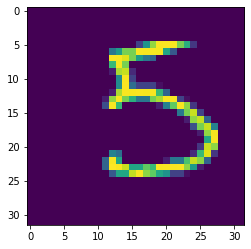

In [ ]:
# Show test image and predicted label
img, label = test_dataset[15]
plt.imshow(img[0])
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 3 - three , Predicted: 6 - six


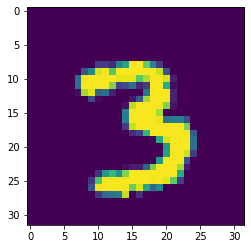

In [ ]:
# Show test image and predicted label
img, label = test_dataset[500]
plt.imshow(img[0])
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 7 - seven , Predicted: 6 - six


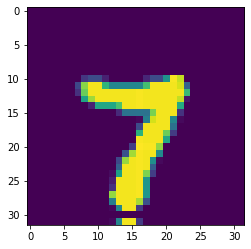

In [ ]:
# Show test image and predicted label
img, label = test_dataset[1100]
plt.imshow(img[0])
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# Show overall loss and accuracy of the model
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.09588293731212616, 'val_loss': 3.520814895629883}